<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_Mallien_vertailu_%2B_Visualisoinnit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Model Comparison Script (LogReg, XGBoost, LightGBM - with Visualizations) ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Datan (weather) käsittely valmis, muoto: (43455, 4)

Yhdistetään otsoni- ja säädata...
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Löytyi 5265 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Piikkien määrittely ---
Piikin kynnysarvo (90. persentiili): 77.10 µg/m³

--- 4. Piirteiden muokkaus ---
Luodaan aikaan perustuvia piirteitä...


<ipython-input-1-813db084cc70>:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)


Luodaan viivepiirteet [1, 2, 3, 6, 12, 24, 48, 72] tunnin jaksoilla...
Luodaan liukuvia tilastoja [3, 6, 12, 24, 48] tunnin ikkunoilla...
Luodaan yhteisvaikutuspiirteitä...
Poistettu 72 riviä piirteiden muokkauksen jälkeen.

--- 5. Datan jako opetus- ja testijoukkoihin ---
Puhdistetaan sarakkeiden nimet...
Lopullinen piirteiden määrä: 66
Opetusdata: 2020-04-04 00:00:00 - 2024-07-02 08:00:00 (37209 riviä)
Testidata: 2024-07-02 09:00:00 - 2025-04-01 23:00:00 (6567 riviä)

--- 6. Skaalataan piirteet ---
Skaalaus valmis.

--- 7. Malli 1: Logistinen Regressio ---
Koulutetaan Logistista Regressiota...
Malli koulutettu.

Logistisen Regression evaluointi:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6110
           1       0.58      0.95      0.72       457

    accuracy                           0.95      6567
   macro avg       0.79      0.95      0.85      6567
weighted avg       0.97      0.95      0.95      6567

Logistisen Regres

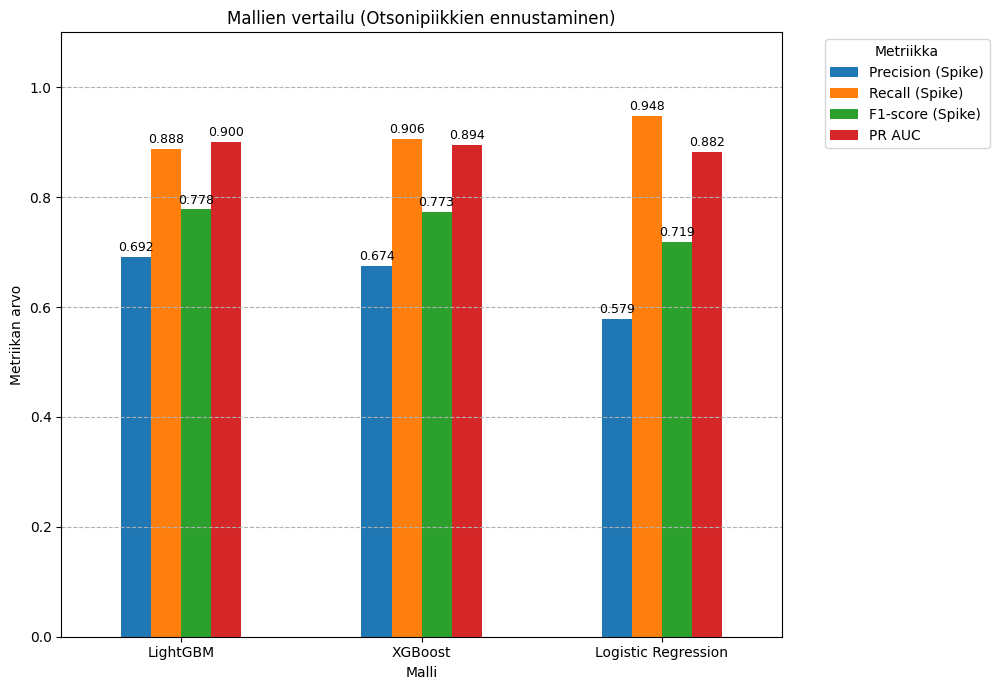


11b. Luodaan Precision-Recall -käyrä (XGBoost)...
PR-käyrä tallennettu: xgboost_pr_curve.png


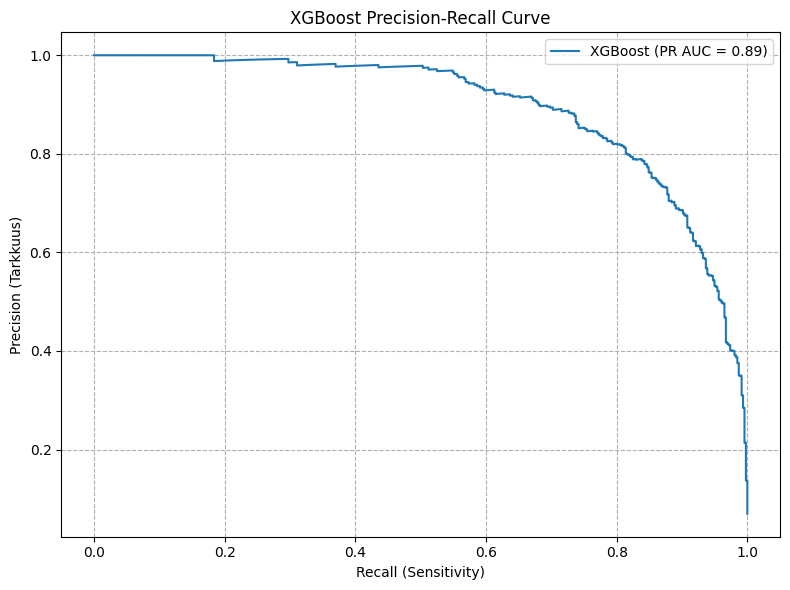


11c. Luodaan piirteiden tärkeys -kaavio (XGBoost)...

XGBoost Piirteiden tärkeys (Top 20):
                               Feature  Importance
12                 Otsoni__µg_m___lag1    0.248212
52         Otsoni__µg_m___roll_mean_3h    0.227158
13                 Otsoni__µg_m___lag2    0.051007
53          Otsoni__µg_m___roll_std_3h    0.026466
64                     temp_x_hour_cos    0.015971
55          Otsoni__µg_m___roll_std_6h    0.014859
20      Lämpötilan_keskiarvo___C__lag1    0.014709
11                       dayofyear_cos    0.012939
5                             hour_cos    0.012407
0               Lämpötilan_keskiarvo_C    0.011747
41  Ilmanpaineen_keskiarvo__hPa__lag24    0.010502
44   Tuulen_suunnan_keskiarvo_____lag1    0.010252
3            Tuulen_suunnan_keskiarvo_    0.009665
17                Otsoni__µg_m___lag24    0.009621
21      Lämpötilan_keskiarvo___C__lag2    0.009300
19                Otsoni__µg_m___lag72    0.008875
49  Tuulen_suunnan_keskiarvo_____lag24   

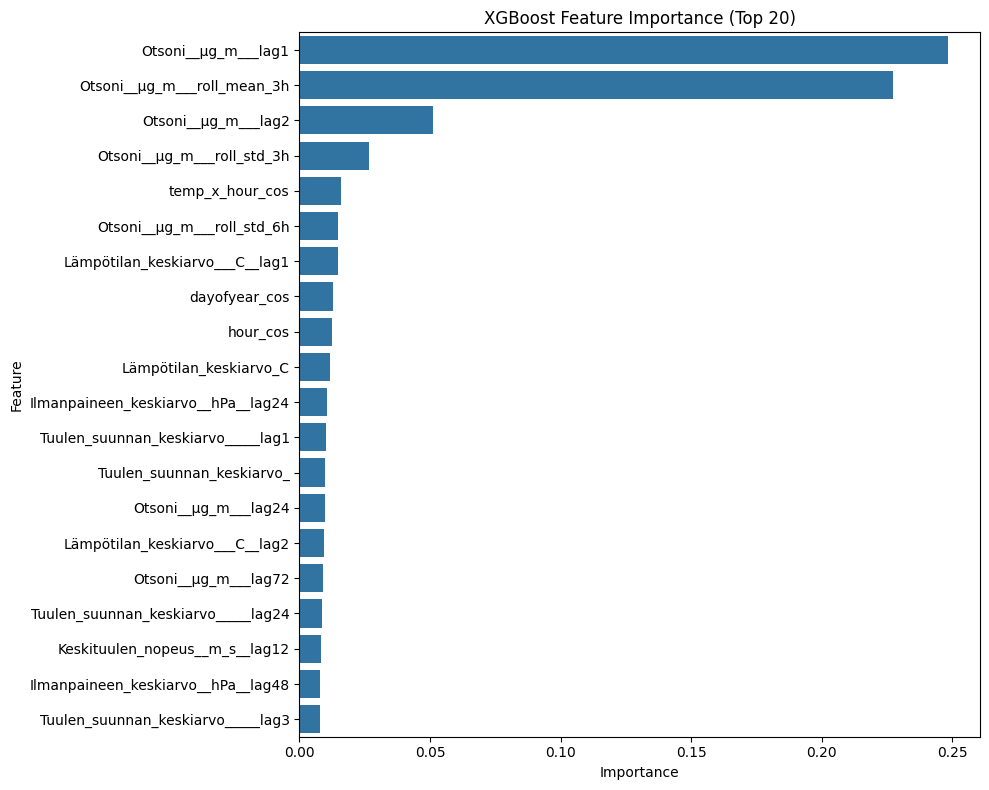


--- Vertailu- ja visualisointiskripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script: Model Comparison + Visualizations (LogReg, XGBoost, LightGBM)

Loads and prepares data, trains all three models, calculates metrics,
stores them for comparison, displays the comparison table, AND generates
comparison plots (bar chart, PR curve, feature importance).
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import xgboost as xgb
import lightgbm as lgb
import re

# Koneoppimiskirjastot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             confusion_matrix, classification_report)

print("--- Model Comparison Script (LogReg, XGBoost, LightGBM - with Visualizations) ---")

# --- Globaali sanakirja mallien vertailuun ---
model_comparison_metrics = {}

# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
# (Sama kuin aiemmin)
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        csv_content = io.StringIO(response.content.decode(encoding))
        if data_type == 'ozone':
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False)
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns: df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")
        elif data_type == 'weather':
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip()
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns: df_local[col] = pd.to_numeric(df_local[col], errors='coerce')
        else: raise ValueError(f"Tuntematon data_type: {data_type}")
        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols): raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")
        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64'); df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64'); df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any(): df_local.dropna(subset=required_dt_cols, inplace=True)
        df_local[year_col] = df_local[year_col].astype(str); df_local[month_col] = df_local[month_col].astype(str).str.zfill(2); df_local[day_col] = df_local[day_col].astype(str).str.zfill(2); df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)
        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else []); missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols: raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()
        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)
        df_local.set_index('Timestamp', inplace=True); df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0: df_local = df_local[~duplicates]
        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local
    except requests.exceptions.RequestException as e: print(f"Virhe datan haussa URL:sta ({data_type}): {e}"); return None
    except Exception as e: print(f"Virhe datan käsittelyssä ({data_type}): {e}"); traceback.print_exc(); return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"
o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]']
df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    df_merged_raw.dropna(inplace=True)
    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        df_merged = df_merged_raw.resample('h').mean()
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)
        if df_merged.isnull().any().any(): df_merged.dropna(inplace=True)
        if df_merged.empty: print("Virhe: Data tyhjä resamplen jälkeen."); df_merged = None
        else: print("Datan yhdistäminen ja resample onnistui.")
    else: print("Virhe: Yhdistetty data tyhjä ennen resamplea."); df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Piikkien määrittely ---
    print("\n--- 3. Piikkien määrittely ---")
    spike_threshold = df_merged[o3_col].quantile(0.90)
    df_merged['onko_piikki'] = (df_merged[o3_col] > spike_threshold).astype(int)
    print(f"Piikin kynnysarvo ({0.90*100:.0f}. persentiili): {spike_threshold:.2f} µg/m³")

    # --- 4. Piirteiden muokkaus ---
    print("\n--- 4. Piirteiden muokkaus ---")
    print("Luodaan aikaan perustuvia piirteitä...")
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged.index.hour / 24); df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged.index.hour / 24)
    df_merged['dayofweek_sin'] = np.sin(2 * np.pi * df_merged.index.dayofweek / 7); df_merged['dayofweek_cos'] = np.cos(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged.index.month / 12); df_merged['month_cos'] = np.cos(2 * np.pi * df_merged.index.month / 12)
    df_merged['dayofyear_sin'] = np.sin(2 * np.pi * df_merged.index.dayofyear / 365.2425); df_merged['dayofyear_cos'] = np.cos(2 * np.pi * df_merged.index.dayofyear / 365.2425)
    features_to_lag = [o3_col] + weather_cols; lag_periods = [1, 2, 3, 6, 12, 24, 48, 72]
    print(f"Luodaan viivepiirteet {lag_periods} tunnin jaksoilla...")
    for col in features_to_lag:
        for lag in lag_periods:
            sanitized_col_name = re.sub(r'[\[\]<>°/³\s]', '_', col)
            df_merged[f'{sanitized_col_name}_lag{lag}'] = df_merged[col].shift(lag)
    rolling_window_hours = [3, 6, 12, 24, 48]
    print(f"Luodaan liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    shifted_o3 = df_merged[o3_col].shift(1); sanitized_o3_col_name = re.sub(r'[\[\]<>°/³\s]', '_', o3_col)
    for window in rolling_window_hours:
        df_merged[f'{sanitized_o3_col_name}_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_merged[f'{sanitized_o3_col_name}_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()
    temp_col = 'Lämpötilan keskiarvo [°C]'; wind_col = 'Keskituulen nopeus [m/s]'; pressure_col = 'Ilmanpaineen keskiarvo [hPa]'
    sanitized_temp_col = re.sub(r'[\[\]<>°/³\s]', '_', temp_col); sanitized_wind_col = re.sub(r'[\[\]<>°/³\s]', '_', wind_col); sanitized_pressure_col = re.sub(r'[\[\]<>°/³\s]', '_', pressure_col)
    df_merged[f'{sanitized_temp_col}_roll_mean_24h'] = df_merged[temp_col].shift(1).rolling(window=24).mean()
    df_merged[f'{sanitized_wind_col}_roll_std_6h'] = df_merged[wind_col].shift(1).rolling(window=6).std()
    print("Luodaan yhteisvaikutuspiirteitä...")
    if 'hour_cos' in df_merged.columns and temp_col in df_merged.columns: df_merged['temp_x_hour_cos'] = df_merged[temp_col] * df_merged['hour_cos']
    if f'{sanitized_pressure_col}_lag1' in df_merged.columns and wind_col in df_merged.columns: df_merged['wind_x_pressure_lag1'] = df_merged[wind_col] * df_merged[f'{sanitized_pressure_col}_lag1']
    initial_rows = len(df_merged); df_merged.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_merged)} riviä piirteiden muokkauksen jälkeen.")
    if df_merged.empty: print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen."); df_merged = None

if df_merged is not None:
    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    target = 'onko_piikki'
    features_orig_names = [col for col in df_merged.columns if col not in [o3_col, target, 'Timestamp']]
    X = df_merged[features_orig_names]
    y = df_merged[target]
    print("Puhdistetaan sarakkeiden nimet...")
    def sanitize_col_names(df_or_list):
        if isinstance(df_or_list, pd.DataFrame): cols = df_or_list.columns
        elif isinstance(df_or_list, list): cols = df_or_list
        else: return df_or_list
        new_cols = []
        for col in cols:
            new_col = str(col); new_col = re.sub(r'[\[\]<>°/³]', '', new_col); new_col = re.sub(r'\s+', '_', new_col)
            if re.match(r'^\d', new_col): new_col = '_' + new_col
            new_cols.append(new_col)
        if isinstance(df_or_list, pd.DataFrame): df_or_list.columns = new_cols; return df_or_list
        elif isinstance(df_or_list, list): return new_cols
    X = sanitize_col_names(X.copy())
    features = X.columns.tolist()
    print(f"Lopullinen piirteiden määrä: {len(features)}")
    test_size = 0.15
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    print(f"Opetusdata: {X_train.index.min()} - {X_train.index.max()} ({len(X_train)} riviä)")
    print(f"Testidata: {X_test.index.min()} - {X_test.index.max()} ({len(X_test)} riviä)")

    # --- 6. Piirteiden skaalaus ---
    print("\n--- 6. Skaalataan piirteet ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
    print("Skaalaus valmis.")

    # --- 7. Malli 1: Logistinen Regressio ---
    print("\n--- 7. Malli 1: Logistinen Regressio ---")
    try:
        log_reg_model = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=200)
        print("Koulutetaan Logistista Regressiota...")
        log_reg_model.fit(X_train_scaled, y_train)
        print("Malli koulutettu.")
        y_pred_logreg = log_reg_model.predict(X_test_scaled)
        y_pred_proba_logreg = log_reg_model.predict_proba(X_test_scaled)[:, 1]
        print("\nLogistisen Regression evaluointi:")
        print(classification_report(y_test, y_pred_logreg, zero_division=0))
        accuracy_logreg = accuracy_score(y_test, y_pred_logreg); precision_spike_logreg = precision_score(y_test, y_pred_logreg, pos_label=1, zero_division=0); recall_spike_logreg = recall_score(y_test, y_pred_logreg, pos_label=1, zero_division=0); f1_spike_logreg = f1_score(y_test, y_pred_logreg, pos_label=1, zero_division=0); roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg); precision_curve_logreg, recall_curve_logreg, _ = precision_recall_curve(y_test, y_pred_proba_logreg); pr_auc_logreg = auc(recall_curve_logreg, precision_curve_logreg)
        model_comparison_metrics['Logistic Regression'] = {
            'Accuracy': accuracy_logreg, 'Precision (Spike)': precision_spike_logreg,
            'Recall (Spike)': recall_spike_logreg, 'F1-score (Spike)': f1_spike_logreg,
            'ROC AUC': roc_auc_logreg, 'PR AUC': pr_auc_logreg }
        print("Logistisen Regression metriikat tallennettu.")
    except Exception as e_logreg: print(f"Virhe Logistisen Regression ajossa: {e_logreg}"); traceback.print_exc()

    # --- 8. Malli 2: XGBoost ---
    print("\n--- 8. Malli 2: XGBoost ---")
    try:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1) if np.sum(y_train == 1) > 0 else 1
        print(f"Laskettu scale_pos_weight: {ratio:.2f}")
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic', eval_metric='logloss', scale_pos_weight=ratio,
            n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8,
            colsample_bytree=0.8, random_state=42, n_jobs=-1)
        print("Koulutetaan XGBoost-mallia...")
        xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
        print("Malli koulutettu.")
        y_pred_xgb = xgb_model.predict(X_test_scaled)
        y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
        print("\nXGBoost-luokittelijan evaluointi:")
        print(classification_report(y_test, y_pred_xgb, zero_division=0))
        accuracy_xgb = accuracy_score(y_test, y_pred_xgb); precision_spike_xgb = precision_score(y_test, y_pred_xgb, pos_label=1, zero_division=0); recall_spike_xgb = recall_score(y_test, y_pred_xgb, pos_label=1, zero_division=0); f1_spike_xgb = f1_score(y_test, y_pred_xgb, pos_label=1, zero_division=0); roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb); precision_curve_xgb, recall_curve_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb); pr_auc_xgb = auc(recall_curve_xgb, precision_curve_xgb)
        model_comparison_metrics['XGBoost'] = {
            'Accuracy': accuracy_xgb, 'Precision (Spike)': precision_spike_xgb,
            'Recall (Spike)': recall_spike_xgb, 'F1-score (Spike)': f1_spike_xgb,
            'ROC AUC': roc_auc_xgb, 'PR AUC': pr_auc_xgb }
        print("XGBoostin metriikat tallennettu.")
    except Exception as e_xgb: print(f"Virhe XGBoost-mallin ajossa: {e_xgb}"); traceback.print_exc()

    # --- 9. Malli 3: LightGBM ---
    print("\n--- 9. Malli 3: LightGBM ---")
    try:
        print(f"Käytetään class_weight='balanced'")
        lgbm_model = lgb.LGBMClassifier(
            objective='binary', metric='logloss', class_weight='balanced',
            n_estimators=100, learning_rate=0.1, num_leaves=31, max_depth=-1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
        print("Koulutetaan LightGBM-mallia...")
        # Käytetään callbackia early stoppingiin LightGBM:lle
        lgbm_model.fit(X_train_scaled, y_train,
                       eval_set=[(X_test_scaled, y_test)],
                       eval_metric='logloss', # Tai 'aucpr'
                       callbacks=[lgb.early_stopping(10, verbose=False)])
        print(f"Malli koulutettu (käytti {lgbm_model.best_iteration_} / {lgbm_model.n_estimators} kierrosta).")
        y_pred_lgbm = lgbm_model.predict(X_test_scaled)
        y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
        print("\nLightGBM-luokittelijan evaluointi:")
        print(classification_report(y_test, y_pred_lgbm, zero_division=0))
        accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm); precision_spike_lgbm = precision_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0); recall_spike_lgbm = recall_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0); f1_spike_lgbm = f1_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0); roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm); precision_curve_lgbm, recall_curve_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm); pr_auc_lgbm = auc(recall_curve_lgbm, precision_curve_lgbm)
        model_comparison_metrics['LightGBM'] = {
            'Accuracy': accuracy_lgbm, 'Precision (Spike)': precision_spike_lgbm,
            'Recall (Spike)': recall_spike_lgbm, 'F1-score (Spike)': f1_spike_lgbm,
            'ROC AUC': roc_auc_lgbm, 'PR AUC': pr_auc_lgbm }
        print("LightGBM:n metriikat tallennettu.")
    except Exception as e_lgbm: print(f"Virhe LightGBM-mallin ajossa: {e_lgbm}"); traceback.print_exc()

    # --- 10. Mallien vertailu ---
    print("\n--- 10. Mallien vertailu ---")
    if model_comparison_metrics:
        comparison_df = pd.DataFrame.from_dict(model_comparison_metrics, orient='index')
        comparison_df = comparison_df.round(4)
        comparison_df.sort_values(by='PR AUC', ascending=False, inplace=True)
        print(comparison_df)

        # --- 11. Visualisoinnit ---
        print("\n--- 11. Visualisoinnit ---")
        # Oletetaan että comparison_df on luotu onnistuneesti
        try:
            # 11a. Pylväskaavio: Mallien vertailu (Avainmetriikat)
            print("\n11a. Luodaan pylväskaavio mallien vertailusta...")
            metrics_to_plot = ['Precision (Spike)', 'Recall (Spike)', 'F1-score (Spike)', 'PR AUC']
            metrics_present = [m for m in metrics_to_plot if m in comparison_df.columns]
            if not metrics_present: print("comparison_df:stä ei löytynyt piirrettäviä metriikoita.")
            else:
                plot_data = comparison_df[metrics_present]
                ax = plot_data.plot(kind='bar', figsize=(12, 7), rot=0)
                for container in ax.containers: ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=9)
                plt.title('Mallien vertailu (Otsonipiikkien ennustaminen)'); plt.ylabel('Metriikan arvo'); plt.xlabel('Malli')
                plt.ylim(0, max(1.1, plot_data.max().max() * 1.1)); plt.legend(title='Metriikka', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', linestyle='--'); plt.tight_layout(rect=[0, 0, 0.85, 1])
                save_path_bar = 'model_comparison_bars.png'
                try: plt.savefig(save_path_bar); print(f"Pylväskaavio tallennettu: {save_path_bar}")
                except Exception as e_save: print(f"Virhe pylväskaavion tallennuksessa: {e_save}")
                plt.show()
        except Exception as e_bar: print(f"Virhe pylväskaavion luonnissa: {e_bar}"); traceback.print_exc()

        # 11b. Precision-Recall -käyrä (XGBoost esimerkkinä)
        print("\n11b. Luodaan Precision-Recall -käyrä (XGBoost)...")
        try:
            # Varmista että tarvittavat muuttujat ovat olemassa
            if 'recall_curve_xgb' in locals() and 'precision_curve_xgb' in locals() and 'pr_auc_xgb' in locals():
                 plt.figure(figsize=(8, 6))
                 plt.plot(recall_curve_xgb, precision_curve_xgb, label=f'XGBoost (PR AUC = {pr_auc_xgb:.2f})')
                 plt.xlabel('Recall (Sensitivity)'); plt.ylabel('Precision (Tarkkuus)'); plt.title('XGBoost Precision-Recall Curve'); plt.legend(); plt.grid(linestyle='--'); plt.tight_layout()
                 save_path_pr = 'xgboost_pr_curve.png'
                 try: plt.savefig(save_path_pr); print(f"PR-käyrä tallennettu: {save_path_pr}")
                 except Exception as e_save: print(f"Virhe PR-käyrän tallennuksessa: {e_save}")
                 plt.show()
            else: print("Tarvittavia muuttujia PR-käyrän piirtämiseen XGBoostille ei löytynyt.")
        except Exception as e_pr: print(f"Virhe PR-käyrän luonnissa: {e_pr}"); traceback.print_exc()

        # 11c. Piirteiden tärkeys (XGBoost esimerkkinä)
        print("\n11c. Luodaan piirteiden tärkeys -kaavio (XGBoost)...")
        try:
            # Varmista että malli ja piirteet ovat olemassa
            if 'xgb_model' in locals() and 'features' in locals() and hasattr(xgb_model, 'feature_importances_'):
                 feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': xgb_model.feature_importances_}).sort_values(by='Importance', ascending=False)
                 print("\nXGBoost Piirteiden tärkeys (Top 20):"); print(feature_importance_df.head(20))
                 plt.figure(figsize=(10, 8)); sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)); plt.title('XGBoost Feature Importance (Top 20)'); plt.tight_layout()
                 save_path_fi = 'xgboost_feature_importance.png'
                 try: plt.savefig(save_path_fi); print(f"Piirteiden tärkeys -kaavio tallennettu: {save_path_fi}")
                 except Exception as e_save: print(f"Virhe piirteiden tärkeys -kaavion tallennuksessa: {e_save}")
                 plt.show()
            else: print("Tarvittavia muuttujia piirteiden tärkeyskaavion luomiseen XGBoostille ei löytynyt.")
        except Exception as e_fi: print(f"Virhe piirteiden tärkeys -kaavion luonnissa: {e_fi}"); traceback.print_exc()

    else:
        print("Metriikoita ei tallennettu vertailua varten, joten visualisointeja ei luoda.")


else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen/muokkaus epäonnistui.")


print("\n--- Vertailu- ja visualisointiskripti päättyi ---")